Back to the main [Index](../index.ipynb)

# Bethe-Saltepeter calculations with AbiPy and Abinit

This lesson discusses how to calculate the macroscopic dielectric function, $\epsilon_\infty(\omega)$, including excitonic effects within the Bethe-Salpeter equation (BSE). 
Crystalline silicon is used as test case. 

For a more detailed description of the Abinit implementation, see the official Abinit 
[BSE tutorial](http://www.abinit.org/documentation/helpfiles/for-v7.10/tutorial/lesson_bse.html).
A brief description of the formalism can be found in the [BSE_notes](http://www.abinit.org/documentation/helpfiles/for-v7.10/tutorial/theory_bse.html)

Note that, unlike many of the previous lessons, in this case we do not provide any `lesson`
object that hides the implementation.
In this tutorial, you are supposed to explore the Abipy objects interactively either inside ipython 
or the ipython notebook.

# Typical BSE flowchart

The flowchart of a typical Bethe-Salpeter run is schematically depicted in the diagram below: 

<img src="http://www.abinit.org/doc/helpfiles/for-v7.8/tutorial/theory_bse/bse_flowchart.png"/>

The WFK file (KSS file in old versions of Abinit) contains the Kohn-Sham (KS) wavefunctions and energies and is represented with an ellipsis. 
The path on the left indicated with blue arrows represents the RPA calculation (`optdriver=3`) that produces the SCR file (see also the first lesson of the $GW$ tutorial). 
Once the WFK (KSS) and the SCR file are available, we can finally contruct the BSE Hamiltonian 
and solve the Bethe-Salpeter problem (the green rectangle at the bottom of the flowchart).

The construction of the Bethe-Salpeter Hamiltonian represents a significant portion of the overall CPU time due to the large number of transitions (bands and in particular $k$-points) needed for an accurate description of the frequency-dependence of the polarizability.

For BSE computations, it is common practice to simulate the self-energy corrections by employing the scissors operator whose value can be obtained either from experiments or from ab-initio calculations. The scissors operator allows one to avoid a costly $GW$ calculation that should performed for all the $k$-points and bands included in the transition space (the optional path on the right indicated with yellow arrows that corresponds to `optdriver=4`).

For this reason, in this lesson, we will employ two commonly used approximations that will
reduce considerably the computational cost of the BSE flowchart while giving reasonably accurate results:

   * The ab-initio $W$ is replaced by a model dielectric function 
     that is constructed from the GS density $n(r)$ and the additional variable `mdf_epsinf`
     that gives the value of the static limit $\epsilon_\infty(\omega=0)$.
     This approximation allows us to bypass the blue boxes in the diagram above (`optdriver=3`)
     
   * The modifications introduced by the $GW$ self-energy on the initial KS band structure
     are approximated with a scissor operator (`soenergy`).
     This approximation allows us bypass the yellow boxes in the diagram above (`optdriver=4`).
      
Under these assumptions, the BSE flowchart reduces to a simple GS-SCF run to get $n(r)$ plus
a NSCF calculation of the band structure on a dense $k$-mesh and, finally, the solution
of the BSE problem (the green box).

# Building an AbiPy flow for BSE calculations with the model dielectric function

In [1]:
# Use %matplotlib if you are running in the ipython shell.
%matplotlib notebook

import abipy.abilab as abilab
import abipy.flowtk as flowtk
from abipy.tools.notebooks import print_source

In [2]:
from abipy.lessons.lesson_bse import make_scf_nscf_bse_inputs

scf_inp, nscf_inp, bse_inp = make_scf_nscf_bse_inputs(ngkpt=(4, 4, 4), ecut=6, ecuteps=3)

The function `make_scf_nscf_bse_inputs` returns three `AbinitInput` objects:

   * The first input (`scf_inp`) solves the KS equations on a Monkhorst-Pack mesh 
     to obtain the groud-state density $n(r)$.

   * The second input (`nscf_inp`) uses the density produced by `scf_inp` to compute 
     the KS band-structure on a **randomly-shifted** $k$-mesh in order to accelerate 
     the convergence of the optical properties wrt the $k$-sampling.

   * Finally, the third input (`bse_inp`) uses the `WFK` file produced in the previous step 
     to solve an approximated BSE equation in which the ab-initio 
     screeened interation $W$ is approximated
     by a model dielectric function that depends only on $n(r)$ and the input variable `mdf_epsinf`
     that gives the value of $\epsilon_\infty(0)$

The variables governing the BSE run are those in the `vargw` section of the Abinit input file:

In [3]:
print(bse_inp)

############################################################################################
#                                      SECTION: varbas                                      
############################################################################################
# <Energy CUToff>
 ecut 6
# <Number of BANDs>
 nband 6
# <KPoinTs OPTion>
 kptopt 1
# <SHIFT for K points>
 shiftk    0.11    0.21    0.31
# <Number of Grid points for K PoinTs generation>
 ngkpt 4 4 4
# <Number of SHIFTs for K point grids>
 nshiftk 1
############################################################################################
#                                      SECTION: vardev                                      
############################################################################################
# <Integer for choice of STorage of WaveFunction at each k point>
 istwfk *1
############################################################################################
#                   

Once we have our three input objects, we can create a flow to automate the calculation.
Note that AbiPy already provides the `BseMdfWork` that is explictly designed for this kind of calculation:

In [4]:
flow = flowtk.Flow(workdir="flow_bse_ecuteps")

# Build a Work for BSE calculation with the model dielectric function
work = flowtk.BseMdfWork(scf_inp, nscf_inp, bse_inp)

# Add it to the flow
flow.register_work(work)

<BseMdfWork, node_id=84335, workdir=flow_bse_ecuteps/w0>

The graphical representation of the flow reveals that the `BseTask` depends on the `NscfTask` that 
in turns depend on the initial `ScfTask`.

<IPython.core.display.Javascript object>


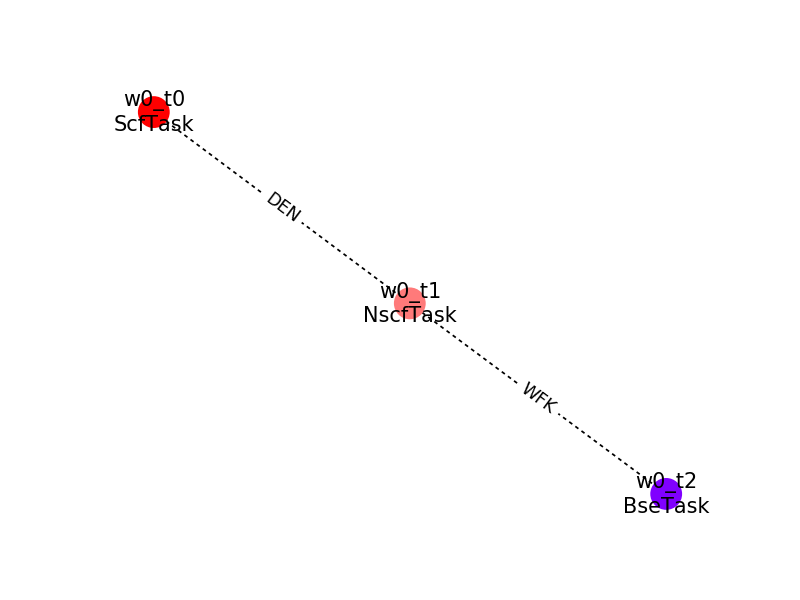

In [5]:
flow.plot_networkx(with_edge_labels=True)

Let's run the flow with:

In [6]:
%%capture
flow.make_scheduler().start()

0

Now we can finally analyze the results. In this case, we are mainly interested in the 
frequency-dependent macroscopic dielectric function, $\epsilon_\infty(\omega)$, produced
by the `BseTask`

In [7]:
# The BseTask is the last task in the first work --> flow[0][2] or, much better flow[0][-1]
bse_task = flow[0][-1]
bse_task

<BseTask, node_id=84338, workdir=flow_bse_ecuteps/w0/t2>

The `BseTask` has produced a netcdf file (`MDF.nc`) containing the most important results of the run. Let's open the file with:

In [8]:
mdf_file = bse_task.open_mdf()

and use `matplotlib` to plot the imaginary part of $\epsilon_\infty(\omega)$

<IPython.core.display.Javascript object>


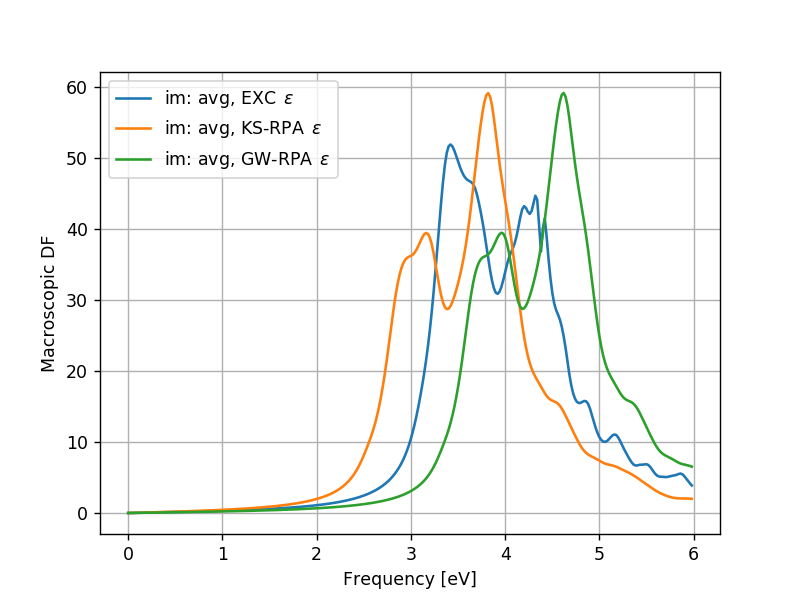

In [9]:
fig = mdf_file.plot_mdfs()

Meaning of the three curves:

   * EXC is $\epsilon_\infty(\omega)$ computed from the BSE with excitonic-effects included
   * KS-RPA is the analogous quantity computed within the RPA and the KS band-structure
   * GW-RPA corresponds to the RPA expression but computed with modified band energies obtained
     by "opening" the KS eigenvalues with a constant scissor operator that tries to mimic 
     the $GW$ corrections (`soenergy` variable)
     
It is worth stressing that:

1) The RPA-KS spectrum underestimates the experimental optical threshold due to the well know band gap problem of DFT. Most importantly, the amplitude of the first peak is underestimated.

2) The RPA-GW results with QP corrections simulated with `soenergy` does not show any significant improvement over RPA-KS: the RPA-GW spectrum is just shifted towards higher frequencies due to opening of the gap, but the shape of the two spectra is very similar, in particular the amplitude of the first peak is still underestimated.

3) On the contrary, the inclusion of the BSE kernel leads to important changes both in the optical threshold as well as in the amplitude of the first peak. This simple analysis tells us that the first peak in the absorption spectrum of silicon has a strong excitonic character that is not correctly described within the RPA. Our first BS spectrum is not converged at all and it barely resembles the experimental result, nevertheless this unconverged calculation is already able to capture the most important physics. 

The difference among the three approaches is schematically depicted in the figure below:

<img src="http://www.abinit.org/doc/helpfiles/for-v8.0/tutorial/theory_bse/schematic_dft_gw_bse.png" /img>

To plot the real part of $\epsilon_\infty(\omega)$

<IPython.core.display.Javascript object>


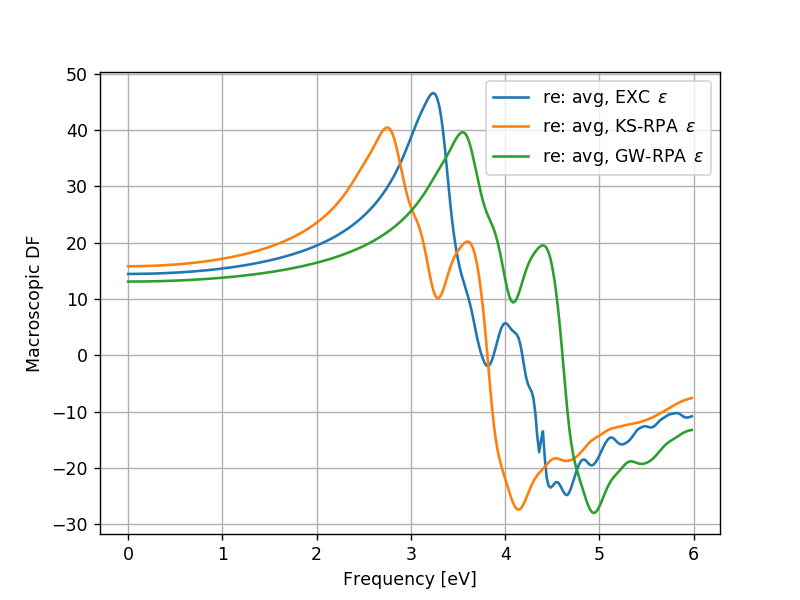

In [10]:
fig = mdf_file.plot_mdfs(cplx_mode="re")

It should be stressed that the screened interaction $W$ is the fundamental ingredient that leads
to the attractive interaction between electrons and holes (excitonic effects).
In a metallic system, the dielectric function is large, $W$ is small and excitonic effects are strongly damped.
To understand this point, we can do a test calculation with a very large value of `mdf_epsinf`
so that our BSE Hamiltonian will be constructed with a metallic $W$:

In [11]:
help(make_scf_nscf_bse_inputs)

Help on function make_scf_nscf_bse_inputs in module abipy.lessons.lesson_bse:

make_scf_nscf_bse_inputs(ngkpt=(6, 6, 6), ecut=6, ecuteps=3, mdf_epsinf=12.0, mbpt_sciss='0.8 eV')
    Build and returns three `AbinitInput` objects to perform a
    GS-SCF + GS-NSCF + BSE calculation with the model dielectric function.
    
    Args:
        ngkpt: Three integers giving the number of divisions for the k-mesh.
        ecut: Cutoff energy for the wavefunctions.
        ecuteps: Cutoff energy for the screened interation W_{GG'}.
        mdf_epsinf: Static limit of the macroscopic dielectric functions.
            Used to build the model dielectric function.
        mbpt_sciss: Scissors operator energy (used to open the initial KS gap).



In [12]:
metalW_flow = flowtk.Flow(workdir="flow_bse_metallicW")

# model dielectric function with metallic W
scf_inp, nscf_inp, bse_inp = make_scf_nscf_bse_inputs(ngkpt=(4, 4, 4), ecut=6, ecuteps=3, 
                                                      mdf_epsinf=1.0e+12)

metalW_flow.register_work(flowtk.BseMdfWork(scf_inp, nscf_inp, bse_inp))

<BseMdfWork, node_id=84340, workdir=flow_bse_metallicW/w0>

In [13]:
%%capture
metalW_flow.make_scheduler().start()

0

<IPython.core.display.Javascript object>


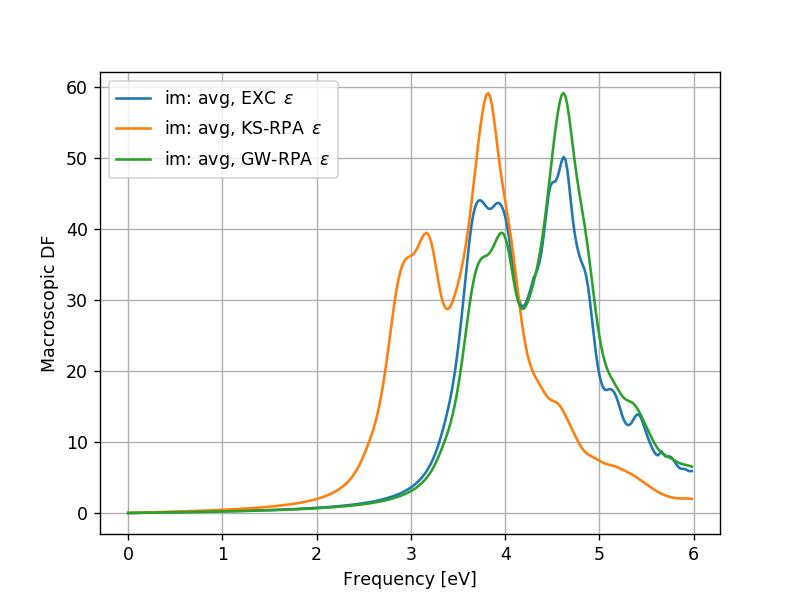

In [14]:
with metalW_flow[0][-1].open_mdf() as mdf_file:
    mdf_file.plot_mdfs()

As you can see, the EXC curve computed with a metallic $W$ 
is similar to the results obtained in GW-RPA.
In particular the first peak is now shifted towards higher frequencies and its amplitude
is decreased when compared to the previous results. 
This behaviour can be easily understood if we consider that 
the BSE formalism reduces to the RPA if $W$ tends to 0.
The EXC curve is still shifted towards higher frequencies when compared with KS-RPA 
but this effect is mainly due to the scissor operator that opens the KS gap.
A similar calculation done with `soenergy=0` would give an EXC curve similar to KS-RPA.
This test is left as an optional exercise. 

# Converge study with respect to the $k$-point sampling

The most important parameter that should be checked for convergence is the number of $k$-points. 
This convergence study represents the most tedious and difficult part since it requires the generation of new WFK files for each k-mesh 
(the list of $k$-points for the wavefunctions and the set of $q$-points in the screening must be consistent with each other)

In the previous paragraph, we have shown how to build a flow for BSE calculation with a fixed 
$k$-points sampling. 
We can thus reuse the same logic to construct a `Flow` made of multiple `BseMdfWorks`, 
each `Work` will have a different $k$-point sampling.

Let's create, for example, a `Flow` that solves that BSE equation on 
a `4x4x4`, `6x6x6` and a `8x8x8` $k$-mesh:

In [15]:
flow = flowtk.Flow(workdir="flow_bse_kconv")

for nk in [4, 6, 8]:
    scf_inp, nscf_inp, bse_inp = make_scf_nscf_bse_inputs(ngkpt=3 * [nk], ecut=6, ecuteps=3)
    work = flowtk.BseMdfWork(scf_inp, nscf_inp, bse_inp)
    flow.register_work(work)

In [16]:
#flow.plot_networkx()

Now we can run our `Flow` with the scheduler (it will take some time)

In [17]:
%%capture
flow.make_scheduler().start()

0

Our `Flow` has three `BseTasks` and therefore three different `MDF.nc` files containing $\epsilon_\infty(\omega)$.

In order to plot the three $\epsilon_\infty(\omega)$ on the same graph, we have use the `MdfRobot`
that will gather the results for us:

In [18]:
robot = abilab.MdfRobot.from_flow(flow)
print(robot)

MdfRobot with 3 files in memory
  [0] flow_bse_kconv/w0/t2/outdata/out_MDF.nc
  [1] flow_bse_kconv/w1/t2/outdata/out_MDF.nc
  [2] flow_bse_kconv/w2/t2/outdata/out_MDF.nc


We can now finally compare the imaginary and the real part of $\epsilon_\infty(\omega)$ with `matplotlib`:

<IPython.core.display.Javascript object>


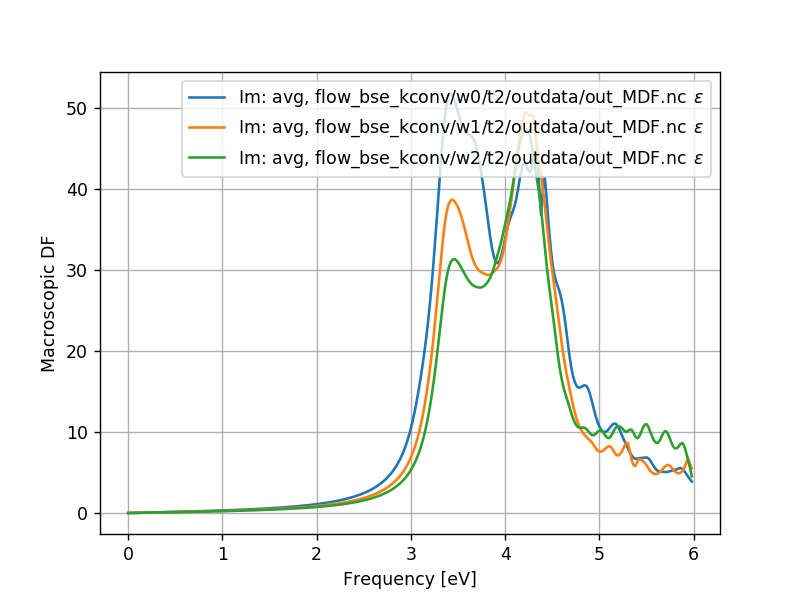

In [19]:
plotter = robot.get_mdf_plotter()
figure = plotter.plot()

<IPython.core.display.Javascript object>


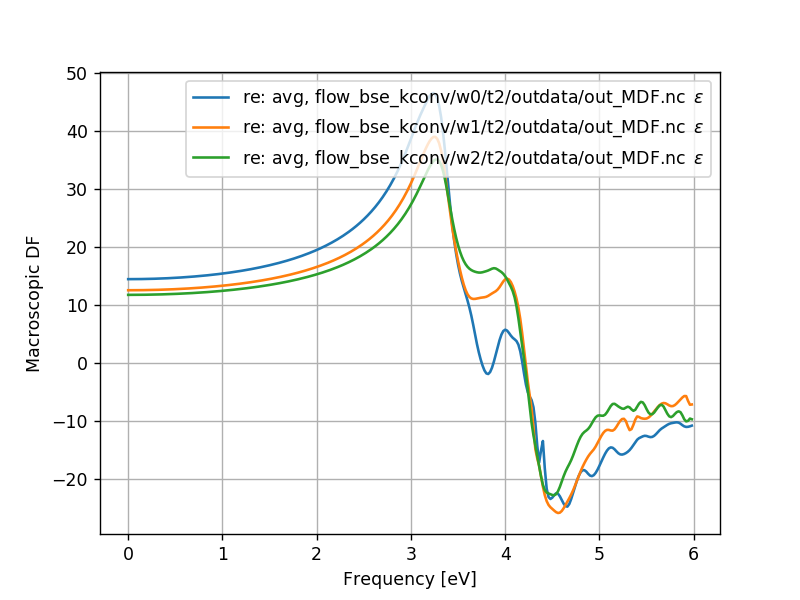

In [20]:
figure = plotter.plot(cplx_mode="re")

## Exercises

Use `make_scf_nscf_bse_inputs` and `BseMdfWork` to perform the following convergence studies:
    
   * Convergence with respect to the number of planewaves in the screening (`ecuteps`)
   * Convergence with respect to the number of $k$-points 
   
See also the discussion reported in the official [BSE tutorial](http://www.abinit.org/documentation/helpfiles/for-v7.10/tutorial/lesson_bse.html)